# Implementing an LSTM Model Over Streamflow
@author: Carson DeSotel  
@date: 2021-11-13  

In [6]:
'''
    Get Time Series Data
'''
### Import Modules
#import sys
#!{sys.executable} -m pip install climata
import climata
from climata.usgs import InstantValueIO
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import numpy as np

### Define Target Stream
_TARGET     = '05372995'

### Define NWIS Code for Streamflow data
_STREAMFLOW = '00060'

### Define Date Ranges for Data Collection as Immutable Tuples
date_ranges = [('2021-04-01', '2021-09-30'), ]

for date_range in date_ranges:
    ### Get Streamflow Data in date_range
    flow_data = InstantValueIO(
        start_date = date_range[0], # get starting date
        end_date   = date_range[1], # get ending date
        station    = _TARGET,       # get target stream     
        parameter  = _STREAMFLOW,   # plug in streamflow code (ft^3 / s)
    )
    
    for flow_series in flow_data:
        flow    = [r[1] for r in flow_series.data]
        dates  = [r[0] for r in flow_series.data]

### Convert to Pandas Series Objects
dates = pd.Series(pd.to_datetime(dates, 
                                 utc = True))
flow   = pd.Series(flow)

### Construct DataFrame from Pandas Series
df = { 'Dates': dates, 
       'Flow' : flow }
df = pd.DataFrame(df)

### Print Length to Show Difference in Data Size
print(len(df['Dates']))

### Plot Original Figure
plt.figure(figsize=(20, 5)) # width, height
plt.plot(df['Dates'], df['Flow']) # y-axis, x-axis
plt.xlabel('Date')
plt.ylabel('Streamflow (ft^3 / s)')
plt.title('South Fork Zumbro River at Rochester, MN - All streamflow data')
plt.xticks(rotation='vertical')
plt.show()

### Filter DataFrame to Only Hourly Values
df = df[df['Dates'].dt.minute == 0]
        
### Print Length to Show Difference in Data Size
print(len(df['Dates']))

### Plot Hourly Figure
plt.figure(figsize=(20, 5)) # width, height
plt.plot(df['Dates'], df['Flow']) # y-axis, x-axis
plt.xlabel('Date')
plt.ylabel('Streamflow (ft^3 / s)')
plt.title('South Fork Zumbro River at Rochester, MN - Hourly streamflow data')
plt.xticks(rotation='vertical')
plt.show()

NameError: name 'basestring' is not defined

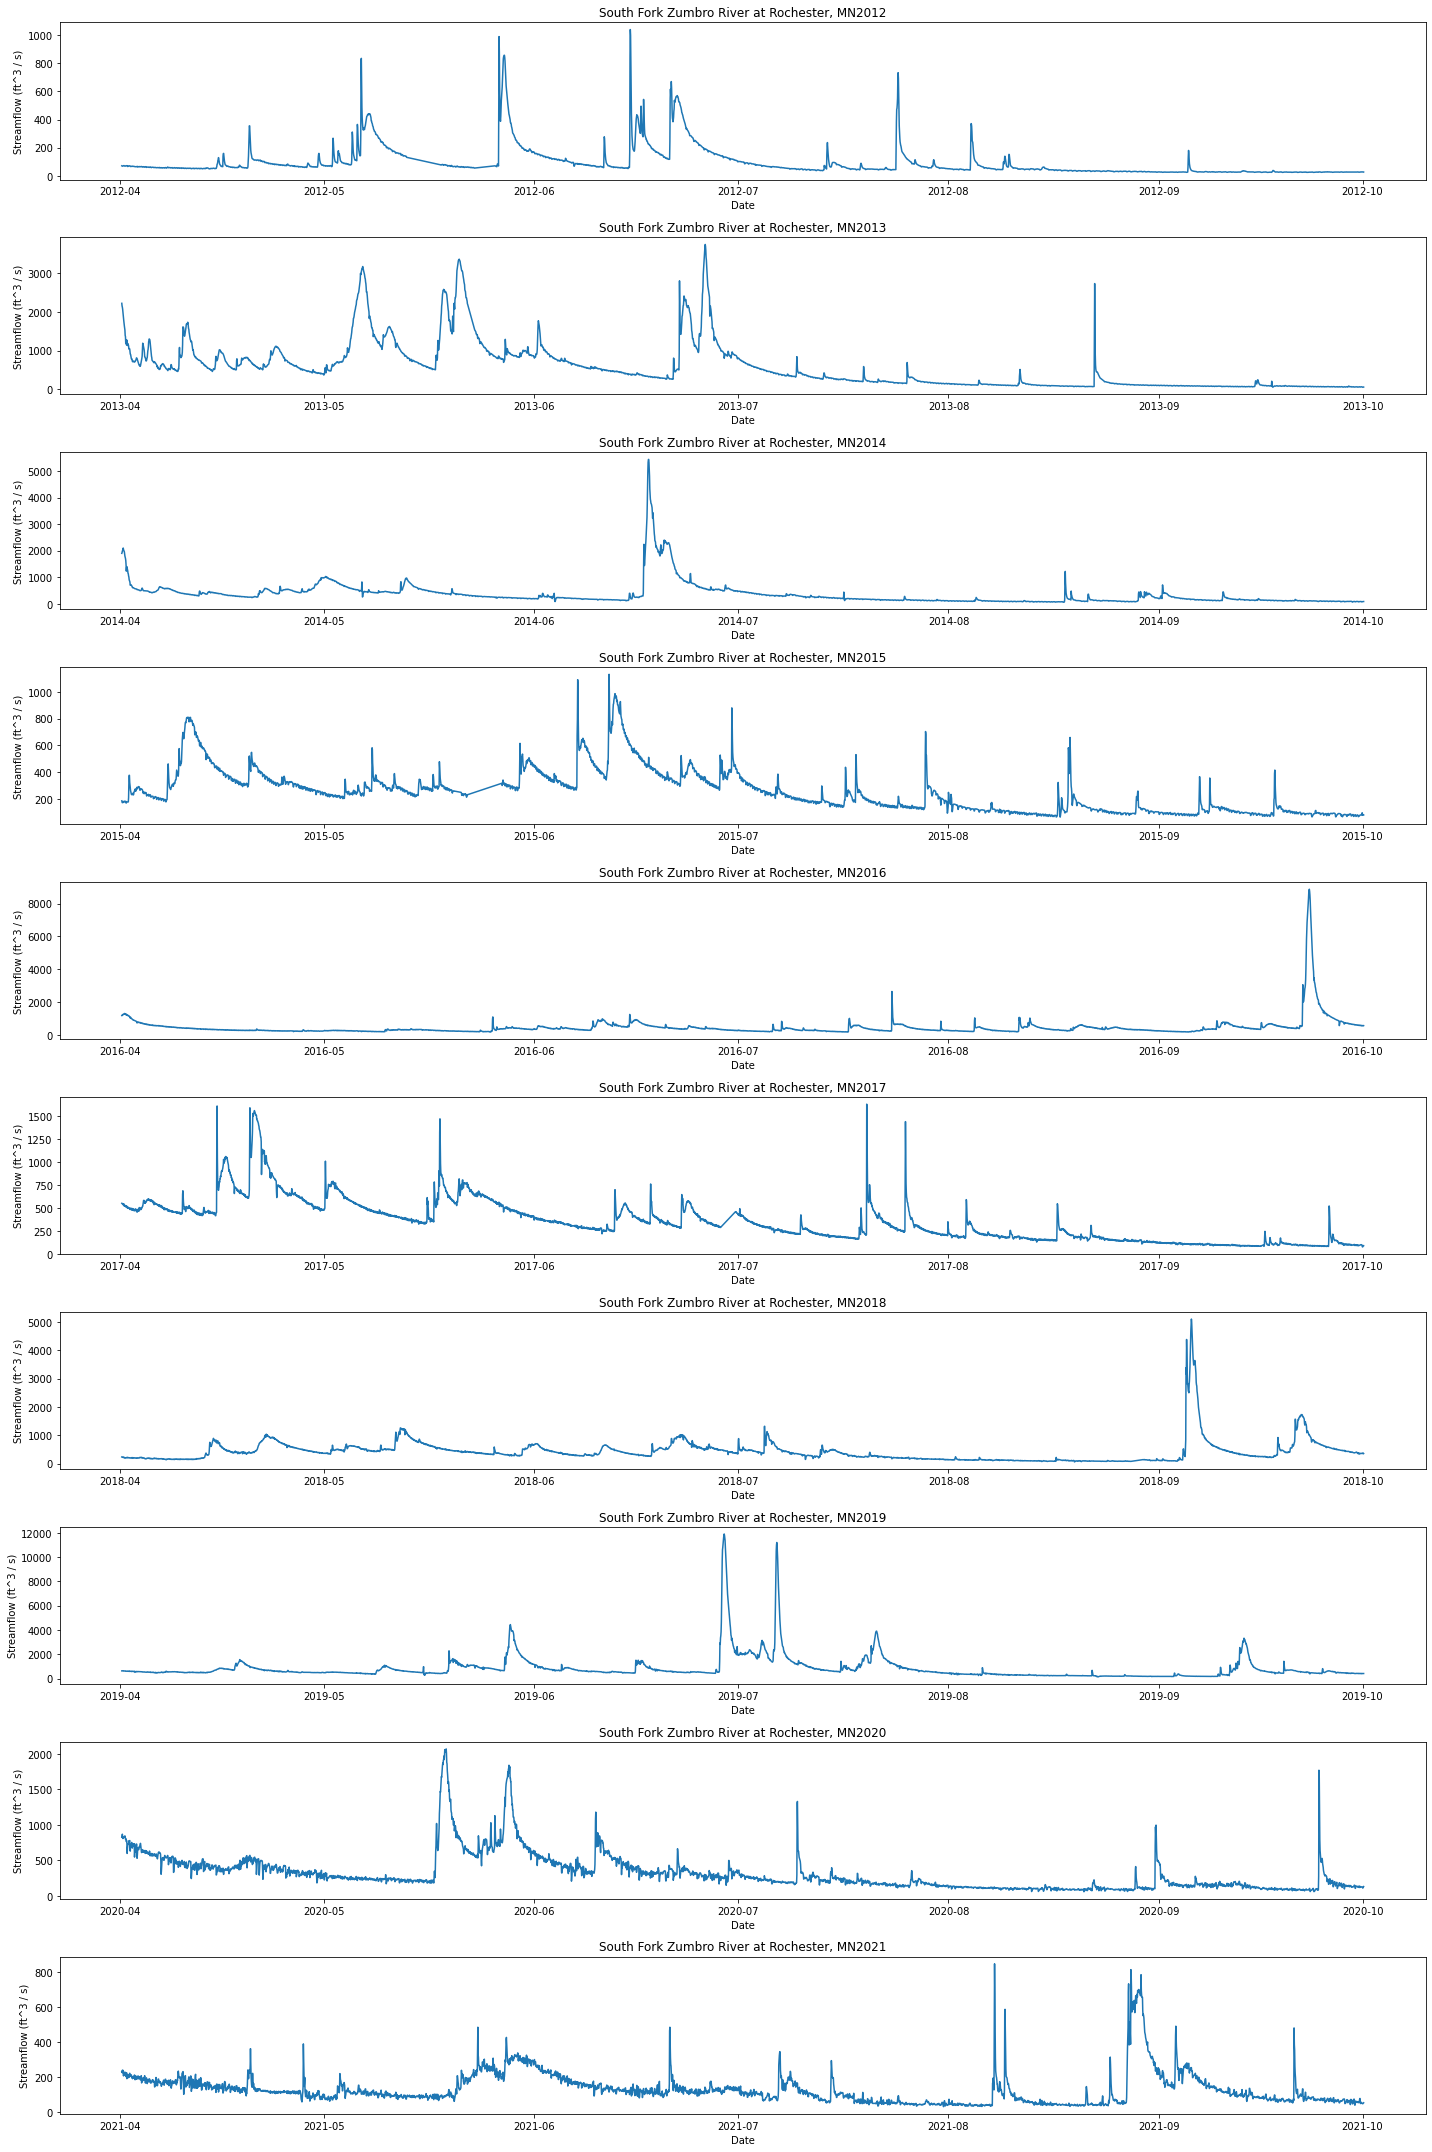

In [2]:
'''
    Extract a few years data
'''
### Import Modules
from climata.usgs import InstantValueIO
import matplotlib.pyplot as plt
import pandas as pd
import datetime

### Define Target Stream
_TARGET     = '05372995'

### Define NWIS Code for Streamflow data
_STREAMFLOW = '00060'

### Define 10 Year Range
date_ranges = [('2012-04-01', '2012-09-30'),
               ('2013-04-01', '2013-09-30'),
               ('2014-04-01', '2014-09-30'),
               ('2015-04-01', '2015-09-30'),
               ('2016-04-01', '2016-09-30'),
               ('2017-04-01', '2017-09-30'),
               ('2018-04-01', '2018-09-30'),
               ('2019-04-01', '2019-09-30'),
               ('2020-04-01', '2020-09-30'),
               ('2021-04-01', '2021-09-30'), ]

### Define List of DataFrames
data_frames = []

fig, axes = plt.subplots(nrows  = 10, 
                        ncols  = 1, 
                        figsize = (20, 30)) # width, height
ax = axes.ravel() # convert 2D to 1D array


index = 0 # set index counter
for date_range in date_ranges:
    ### Get Streamflow Data in date_range
    flow_data = InstantValueIO(
        start_date = date_range[0], # get starting date
        end_date   = date_range[1], # get ending date
        station    = _TARGET,       # get target stream     
        parameter  = _STREAMFLOW,   # plug in streamflow code (ft^3 / s)
    )
    
    ### Gather Flow Series data
    for flow_series in flow_data:
        flow    = [r[1] for r in flow_series.data]
        dates  = [r[0] for r in flow_series.data]
        
        ### Convert to Pandas Series Objects
        dates = pd.Series(pd.to_datetime(dates, utc = True))
        flow   = pd.Series(flow)

        ### Construct DataFrame from Pandas Series
        df = { 'Dates': dates, 
               'Flow' : flow }
        df = pd.DataFrame(df)

        ### Filter DataFrame to Only Hourly Values
        df = df[df['Dates'].dt.minute == 0]
        
        ### Add to List of Data Frames
        data_frames.append(df)
        
        ### Plot Each DataFrame
        ax[index].plot(df['Dates'], df['Flow'])
        ax[index].set_title('South Fork Zumbro River at Rochester, MN' + str(dates.dt.year[0]))
        ax[index].set_xlabel('Date')
        ax[index].set_ylabel('Streamflow (ft^3 / s)')
        index += 1
plt.tight_layout()
plt.show()

In [1]:
'''
    Machine Learning Test
    from https://towardsdatascience.com/3-steps-to-forecast-time-series-lstm-with-tensorflow-keras-ba88c6f05237
'''
### Import Modules
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import Sequence
import datetime
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import numpy as np
import pandas as pd
import time

import os

from climata.usgs import InstantValueIO
import matplotlib.pyplot as plt

### Define Target Stream
_TARGET     = '05372995'

### Define NWIS Code for Streamflow data
_STREAMFLOW = '00060'

### Define Date Ranges for Data Collection as Immutable Tuples
date_ranges = [('2021-09-01', '2021-09-30'), ]

for date_range in date_ranges:
    ### Get Streamflow Data in date_range
    flow_data = InstantValueIO(
        start_date = date_range[0], # get starting date
        end_date   = date_range[1], # get ending date
        station    = _TARGET,       # get target stream     
        parameter  = _STREAMFLOW,   # plug in streamflow code (ft^3 / s)
    )
    
    for flow_series in flow_data:
        flow    = [r[1] for r in flow_series.data]
        dates  = [r[0] for r in flow_series.data]

### Convert to Pandas Series Objects
dates = pd.Series(pd.to_datetime(dates, 
                                 utc = True))
flow   = pd.Series(flow)

### Construct DataFrame from Pandas Series
df = { 'Dates': dates, 
       'Flow' : flow }
df = pd.DataFrame(df)

### Define Training / Validation Date Ranges
test_cutoff  = df['Dates'].max() - timedelta(days=7)
valid_cutoff = test_cutoff - timedelta(days=14)

### Isolate Training / Validation Dates
df_test  = df[df['Dates'] > test_cutoff]
df_valid = df[(df['Dates'] > valid_cutoff) & (df['Dates'] <= test_cutoff)]
df_train = df[df['Dates'] <= valid_cutoff]

ModuleNotFoundError: No module named 'tensorflow'

In [13]:
'''
    Import External Preciptation Data
'''
import pandas as pd

roch_temp = pd.read_csv('roch_temp_hourly_cleaned.csv', parse_dates=[['Date', 'Time']])

# print(df.head(10))
# print(df.tail(10))

In [24]:
print(list(roch_temp.columns))
roch_temp = pd.read_csv('roch_temp_hourly_cleaned.csv', parse_dates=[['Date', 'Time']])
precip = pd.concat([roch_temp['DT Round'], roch_temp['Temp (F)'], roch_temp['RH (%)'], roch_temp['Wind Spd (mph)']], axis = 1)
precip['DT Round'] = pd.to_datetime(precip['DT Round'], utc = True)
precip.rename(columns = {'DT Round' : 'Dates'}, inplace = True)


print(precip.head(10))

['Date_Time', 'Temp (F)', 'RH (%)', 'Wind Spd (mph)', 'DT Combo', 'DT Round']
                      Dates Temp (F) RH (%) Wind Spd (mph)
0 2012-03-01 01:00:00+00:00       33     91             14
1 2012-03-01 02:00:00+00:00       32     92             17
2 2012-03-01 03:00:00+00:00       32     88             14
3 2012-03-01 04:00:00+00:00       32     85             11
4 2012-03-01 05:00:00+00:00       32     81             11
5 2012-03-01 06:00:00+00:00       31     88              7
6 2012-03-01 07:00:00+00:00       31     88              9
7 2012-03-01 08:00:00+00:00       31     85              6
8 2012-03-01 09:00:00+00:00       32     80              5
9 2012-03-01 10:00:00+00:00       33     75              7


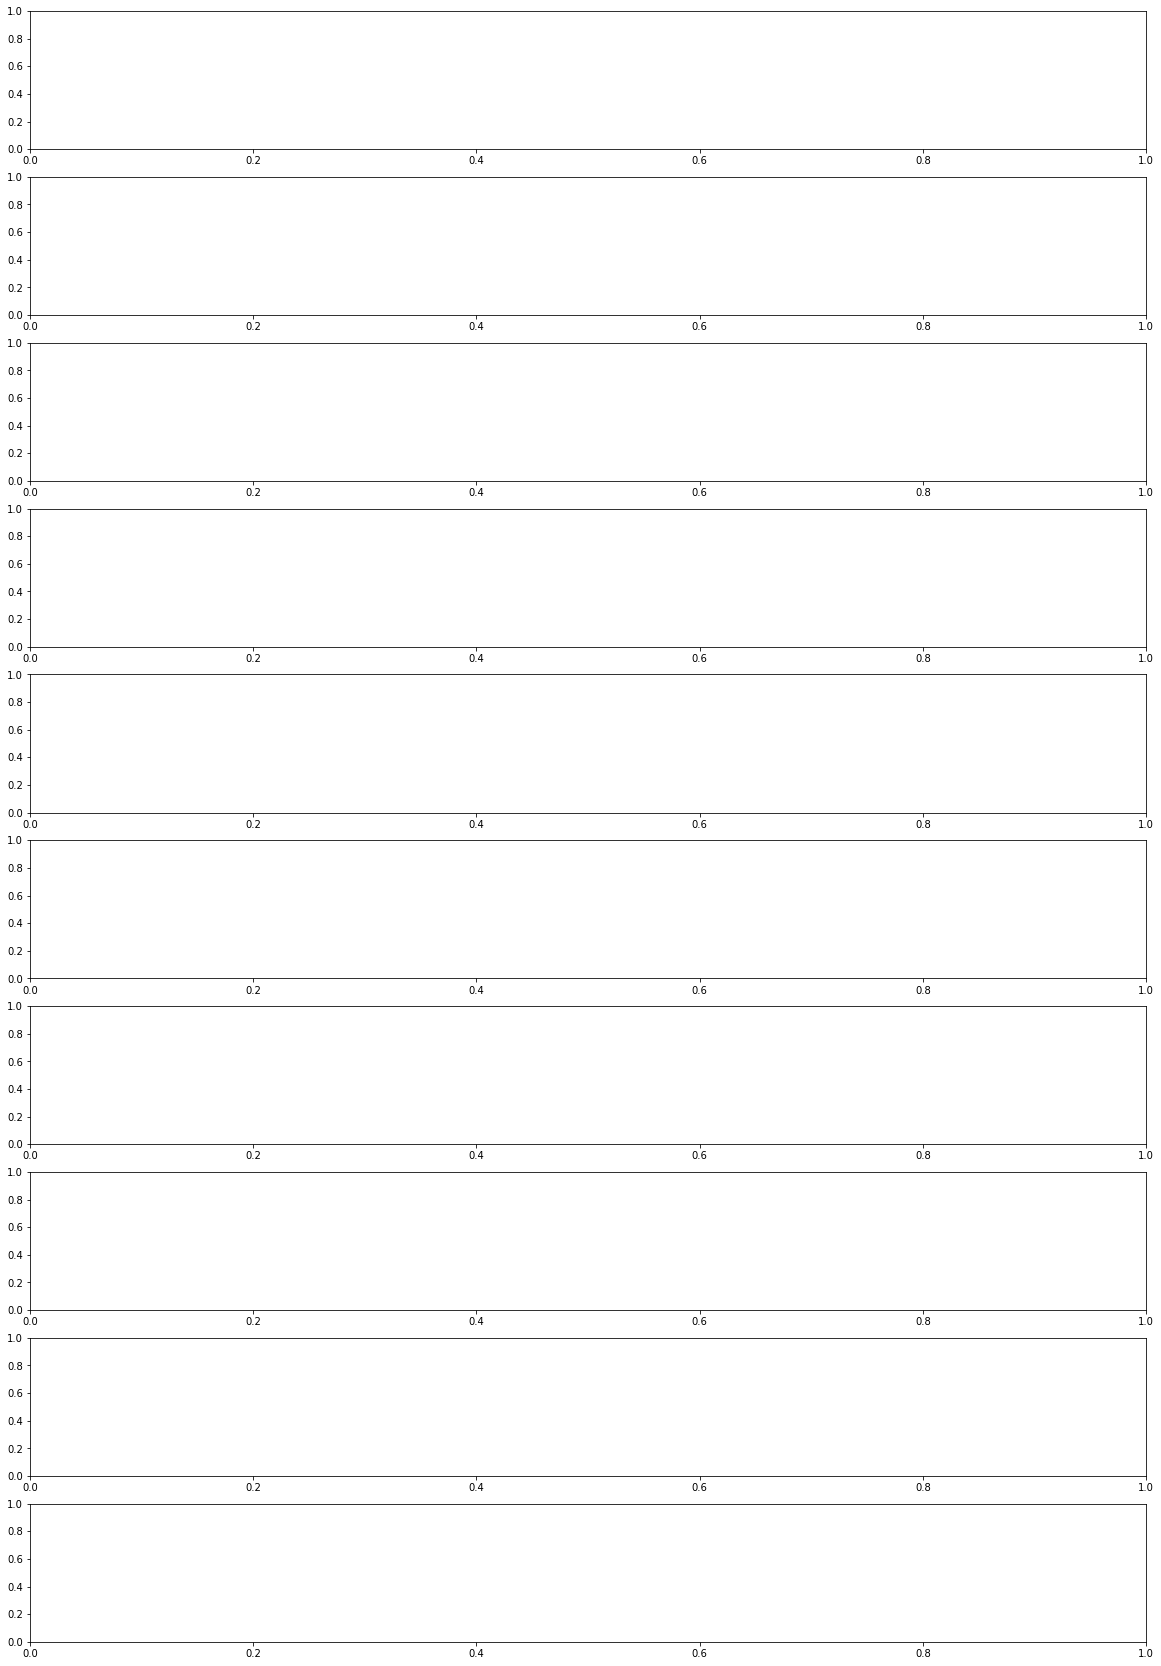

In [9]:
'''
    Weave Hydrographs with Precipitation Data
'''

### Import Modules
from climata.usgs import InstantValueIO
import matplotlib.pyplot as plt
import pandas as pd
import datetime

### Define Target Stream
_TARGET     = '05372995'

### Define NWIS Code for Streamflow data
_STREAMFLOW = '00060'

### Define 10 Year Range
date_ranges = [('2012-04-01', '2012-09-30'),
               ('2013-04-01', '2013-09-30'),
               ('2014-04-01', '2014-09-30'),
               ('2015-04-01', '2015-09-30'),
               ('2016-04-01', '2016-09-30'),
               ('2017-04-01', '2017-09-30'),
               ('2018-04-01', '2018-09-30'),
               ('2019-04-01', '2019-09-30'),
               ('2020-04-01', '2020-09-30'),
               ('2021-04-01', '2021-09-30'), ]

### Define List of DataFrames
data_frames = []

fig, axes = plt.subplots(nrows  = 10, 
                        ncols  = 1, 
                        figsize = (20, 30)) # width, height
ax = axes.ravel() # convert 2D to 1D array


index = 0 # set index counter
for date_range in date_ranges:
    ### Get Streamflow Data in date_range
    flow_data = InstantValueIO(
        start_date = date_range[0], # get starting date
        end_date   = date_range[1], # get ending date
        station    = _TARGET,       # get target stream     
        parameter  = _STREAMFLOW,   # plug in streamflow code (ft^3 / s)
    )
    
    ### Gather Flow Series data
    for flow_series in flow_data:
        flow    = [r[1] for r in flow_series.data]
        dates  = [r[0] for r in flow_series.data]
        
        ### Convert to Pandas Series Objects
        dates = pd.Series(pd.to_datetime(dates, utc = True))
        flow   = pd.Series(flow)

        ### Construct DataFrame from Pandas Series
        df = { 'Dates': dates, 
               'Flow' : flow }
        df = pd.DataFrame(df)

        ### Filter DataFrame to Only Hourly Values
        df = df[df['Dates'].dt.minute == 0]
        
        ### Add to List of Data Frames
        data_frames.append(df)

### Merge Hyrdograph DataFrames
super_df = pd.concat(data_frames)

In [10]:
print(super_df.head(10))
print(super_df.tail(10))

                      Dates  Flow
0 2012-04-01 05:00:00+00:00  70.6
1 2012-04-01 06:00:00+00:00  69.3
2 2012-04-01 07:00:00+00:00  68.0
3 2012-04-01 08:00:00+00:00  68.0
4 2012-04-01 09:00:00+00:00  69.3
5 2012-04-01 10:00:00+00:00  70.6
6 2012-04-01 11:00:00+00:00  70.6
7 2012-04-01 12:00:00+00:00  71.9
8 2012-04-01 13:00:00+00:00  71.9
9 2012-04-01 14:00:00+00:00  70.6
                          Dates  Flow
17312 2021-09-30 19:00:00+00:00  57.9
17316 2021-09-30 20:00:00+00:00  55.0
17320 2021-09-30 21:00:00+00:00  52.2
17324 2021-09-30 22:00:00+00:00  52.2
17328 2021-09-30 23:00:00+00:00  52.1
17332 2021-10-01 00:00:00+00:00  49.4
17336 2021-10-01 01:00:00+00:00  49.4
17340 2021-10-01 02:00:00+00:00  50.8
17344 2021-10-01 03:00:00+00:00  53.5
17348 2021-10-01 04:00:00+00:00  54.9


In [29]:
super_ultra_mega_df = pd.merge(precip, super_df, how='inner', on=['Dates'])
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(super_ultra_mega_df[:5000])

                         Dates Temp (F) RH (%) Wind Spd (mph)    Flow
0    2012-04-01 05:00:00+00:00       41     95             10    70.6
1    2012-04-01 06:00:00+00:00       41    100              8    69.3
2    2012-04-01 07:00:00+00:00       43    100             11    68.0
3    2012-04-01 08:00:00+00:00       46     92              9    68.0
4    2012-04-01 09:00:00+00:00       49     86              9    69.3
5    2012-04-01 10:00:00+00:00       54     77             11    70.6
6    2012-04-01 11:00:00+00:00       57     74             10    70.6
7    2012-04-01 12:00:00+00:00       60     66             13    71.9
8    2012-04-01 13:00:00+00:00       65     58             10    71.9
9    2012-04-01 14:00:00+00:00       66     58             11    70.6
10   2012-04-01 15:00:00+00:00       67     56             14    69.3
11   2012-04-01 16:00:00+00:00       66     58             16    68.0
12   2012-04-01 17:00:00+00:00       64     62             17    68.0
13   2012-04-01 18:0

In [31]:
'''
    Form Final ML Dataset
'''
### Import Modules
from climata.usgs import InstantValueIO
import matplotlib.pyplot as plt
import pandas as pd
import datetime

### Define Target Stream
_TARGET     = '05372995'

### Define NWIS Code for Streamflow data
_STREAMFLOW = '00060'

### Define NWIS Code for Precipitation data
_PRECIPITATION = '00045'

### Define 10 Year Range
date_ranges = [('2012-04-01', '2012-09-30'),
               ('2013-04-01', '2013-09-30'),
               ('2014-04-01', '2014-09-30'),
               ('2015-04-01', '2015-09-30'),
               ('2016-04-01', '2016-09-30'),
               ('2017-04-01', '2017-09-30'),
               ('2018-04-01', '2018-09-30'),
               ('2019-04-01', '2019-09-30'),
               ('2020-04-01', '2020-09-30'),
               ('2021-04-01', '2021-09-30'), ]


### Step 1: Get Flow Data

### Define List of flow DataFrames
flow_data_frames = []

index = 0 # set index counter
for date_range in date_ranges:
    ### Get Streamflow Data in date_range
    flow_data = InstantValueIO(
        start_date = date_range[0], # get starting date
        end_date   = date_range[1], # get ending date
        station    = _TARGET,       # get target stream     
        parameter  = _STREAMFLOW,   # plug in streamflow code (ft^3 / s)
    )
    
    ### Gather Flow Series data
    for flow_series in flow_data:
        flow    = [r[1] for r in flow_series.data]
        dates  = [r[0] for r in flow_series.data]
        
        ### Convert to Pandas Series Objects
        dates = pd.Series(pd.to_datetime(dates, utc = True))
        flow   = pd.Series(flow)

        ### Construct DataFrame from Pandas Series
        df = { 'Dates': dates, 
               'Flow (ft^3 / s)' : flow }
        df = pd.DataFrame(df)

        ### Filter DataFrame to Only Hourly Values
        df = df[df['Dates'].dt.minute == 0]
        
        ### Add to List of Data Frames
        flow_data_frames.append(df)

### Merge Hyrdograph DataFrames
flow_df = pd.concat(flow_data_frames)

### Step 2: Get Precipitation Data

### Define List of Precipitation Data Frames
precip_data_frames = []

index = 0 # set index counter
for date_range in date_ranges:
    ### Get Precipitation Data in date_range
    precip_data = InstantValueIO(
        start_date = date_range[0], # get starting date
        end_date   = date_range[1], # get ending date
        station    = _TARGET,       # get target stream     
        parameter  = _PRECIPITATION,   # plug in streamflow code (ft^3 / s)
    )
    
    ### Gather Flow Series data
    for precip_series in precip_data:
        precip = [r[1] for r in precip_series.data]
        dates  = [r[0] for r in precip_series.data]
        
        ### Convert to Pandas Series Objects
        dates = pd.Series(pd.to_datetime(dates, utc = True))
        prec  = pd.Series(precip)

        ### Construct DataFrame from Pandas Series
        df = { 'Dates' : dates, 
               'Precipitation (in)' : prec }
        df = pd.DataFrame(df)

        ### Filter DataFrame to Only Hourly Values
        df = df[df['Dates'].dt.minute == 0]
        
        ### Add to List of Data Frames
        precip_data_frames.append(df)

### Merge Hyrdograph DataFrames
prec_df = pd.concat(precip_data_frames)

### Step 3: Join Into One DataFrame
precip_flow = pd.merge(prec_df, flow_df, how='inner', on=['Dates'])
print(precip_flow.head(10))

                      Dates  Precipitation (in)  Flow (ft^3 / s)
0 2021-07-23 05:00:00+00:00                 0.0             75.0
1 2021-07-23 06:00:00+00:00                 0.0             68.1
2 2021-07-23 07:00:00+00:00                 0.0             47.5
3 2021-07-23 08:00:00+00:00                 0.0             43.7
4 2021-07-23 09:00:00+00:00                 0.0             47.5
5 2021-07-23 10:00:00+00:00                 0.0             52.8
6 2021-07-23 11:00:00+00:00                 0.0             48.8
7 2021-07-23 12:00:00+00:00                 0.0             52.8
8 2021-07-23 13:00:00+00:00                 0.0             64.8
9 2021-07-23 14:00:00+00:00                 0.0             69.8


In [42]:
'''
    Form Final ML Dataset
'''
### Import Modules
from climata.usgs import InstantValueIO
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import numpy as np

### Define Target Stream
_TARGET     = '05372995'

### Define NWIS Code for Streamflow data
_STREAMFLOW = '00060'

### Define NWIS Code for Precipitation data
_PRECIPITATION = '00045'

### Define 10 Year Range
date_ranges = [('2012-04-01', '2012-09-30'),
               ('2013-04-01', '2013-09-30'),
               ('2014-04-01', '2014-09-30'),
               ('2015-04-01', '2015-09-30'),
               ('2016-04-01', '2016-09-30'),
               ('2017-04-01', '2017-09-30'),
               ('2018-04-01', '2018-09-30'),
               ('2019-04-01', '2019-09-30'),
               ('2020-04-01', '2020-09-30'),
               ('2021-04-01', '2021-09-30'), ]


### Step 1: Get Flow Data

### Define List of flow DataFrames
flow_data_frames = []

index = 0 # set index counter
for date_range in date_ranges:
    ### Get Streamflow Data in date_range
    flow_data = InstantValueIO(
        start_date = date_range[0], # get starting date
        end_date   = date_range[1], # get ending date
        station    = _TARGET,       # get target stream     
        parameter  = _STREAMFLOW,   # plug in streamflow code (ft^3 / s)
    )
    
    ### Gather Flow Series data
    for flow_series in flow_data:
        flow    = [r[1] for r in flow_series.data]
        dates  = [r[0] for r in flow_series.data]
        
        ### Convert to Pandas Series Objects
        dates = pd.Series(pd.to_datetime(dates, utc = True))
        flow   = pd.Series(flow)

        ### Construct DataFrame from Pandas Series
        df = { 'Dates': dates, 
               'Flow (ft^3 / s)' : flow }
        df = pd.DataFrame(df)

        ### Filter DataFrame to Only Hourly Values
        df = df[df['Dates'].dt.minute == 0]
        
        ### Add to List of Data Frames
        flow_data_frames.append(df)

### Merge Hyrdograph DataFrames
flow_df = pd.concat(flow_data_frames)

### Load in Cleaned Airport Data
roch_data = pd.read_csv('roch_temp_hourly_cleaned.csv', parse_dates=[['Date', 'Time']])

### Select Specific Columns and concat to DataFrame
roch_data = pd.concat([roch_data['DT Round'], 
                       roch_data['Temp (F)'], 
                       roch_data['RH (%)'], 
                       roch_data['Wind Spd (mph)'],
                       roch_data['Precip (in)']], 
                     axis = 1) # ensure columns


In [43]:
### Convert to DateTime
roch_data['DT Round'] = pd.to_datetime(roch_data['DT Round'], utc = True)

### Rename to Help Merge
roch_data.rename(columns = {'DT Round' : 'Dates'}, inplace = True)

roch_data.set_index('Dates')

print(roch_data)

                          Dates Temp (F) RH (%) Wind Spd (mph) Precip (in)
0     2012-03-01 01:00:00+00:00       33     91             14           0
1     2012-03-01 02:00:00+00:00       32     92             17           m
2     2012-03-01 03:00:00+00:00       32     88             14           0
3     2012-03-01 04:00:00+00:00       32     85             11           0
4     2012-03-01 05:00:00+00:00       32     81             11           0
...                         ...      ...    ...            ...         ...
84721 2021-11-01 20:00:00+00:00       36     66              9           0
84722 2021-11-01 21:00:00+00:00       36     66             10           0
84723 2021-11-01 22:00:00+00:00       35     69              7           0
84724 2021-11-01 23:00:00+00:00       35     72              9           0
84725 2021-11-02 00:00:00+00:00       35     72             13           0

[84726 rows x 5 columns]


In [44]:
### Remove Missing Values in "Precip (in)"
roch_data['Precip (in)'].loc[(roch_data['Precip (in)'] == 'm')] = 0



/home/carson/.local/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [45]:
### And in Wind Spd
roch_data['Wind Spd (mph)'].loc[(roch_data['Wind Spd (mph)'] == 'M')] = 0



In [60]:
### replace M with NaN
roch_data['RH (%)'].loc[(roch_data['RH (%)'] == 'm')] = np.nan
roch_data['Temp (F)'].loc[(roch_data['Temp (F)'] == 'M')] = np.nan

roch_data = roch_data.fillna(method='ffill')

# roch_data.where(roch_data.replace(to_replace='M', value=np.nan),
#  other=(roch_data.fillna(method='ffill') + roch_data.fillna(method='bfill'))/2)

### Step 3: Join Into One DataFrame
final = pd.merge(roch_data, flow_df, how='inner', on=['Dates'])

### Save to Final CSV
#final.to_csv('final_data.csv', index = False)

In [ ]:
# Create simulated sampling data

# add days/hours to dataframe
final['Dates'] = pd.to_datetime(final['Dates'], utc = True)
final['Day'] = final['Dates'].dt.day
final['Hour'] = final['Dates'].dt.hour

# sample mid-month at noon
day1 = 1
day2 = 15
sample_t = 12

# create column for sampling data
final['Sample Flow'] = np.nan

# fill in the sampling data for the first + fifteenth of each month
final.loc[(((final['Day'] == day1) | (final['Day'] == day2))&(final['Hour'] == sample_t)),'Sample Flow'] = final['Flow (ft^3 / s)']

# propogate the sampling data through the dataframe, so that each day is associated
# with the most recent sampling data
final['Sample Flow'] = final['Sample Flow'].fillna(method='ffill')

# drop rows with NaN
final = final.dropna()

# delete columns
final.drop(columns=['Day','Hour'],inplace=True)

In [ ]:
# Calculate 24 hour cumulative precipitation
final['24hr Precip'] = final['Precip (in)'].rolling(window=24).sum()
final = final.dropna()

In [ ]:
# export csv
final.to_csv('final_data_extra_processing.csv', index = False)